In [1]:
import numpy as np
import torch
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import os

In [5]:
from pathlib import Path
import h5py

# 1) block 'blood-oxygen' 
cur = Path.cwd()
bo_root = next(p for p in [cur, *cur.parents] if p.name == "blood-oxygen")

# 2) into spo2-phonecam (subsystem of author)
spo2_root = bo_root / "spo2-phonecam"

# 3) (form the pathway of data.h5)
H5 = (spo2_root / "external/oximetry-phone-cam-data/data/preprocessed/all_uw_data.h5").resolve()
print("Using:", H5)
assert H5.exists(), f"not exist：{H5}"

# 4) read
with h5py.File(H5, "r") as f:
    print("Keys:", list(f.keys()))
    data = f["dataset"][:]
    gt   = f["groundtruth"][:]
print(data.shape, gt.shape)


Using: /Users/katyhuang/Desktop/blood-oxygen/spo2-phonecam/external/oximetry-phone-cam-data/data/preprocessed/all_uw_data.h5
Keys: ['dataset', 'groundtruth']
(6, 6, 33660) (6, 5, 1122)


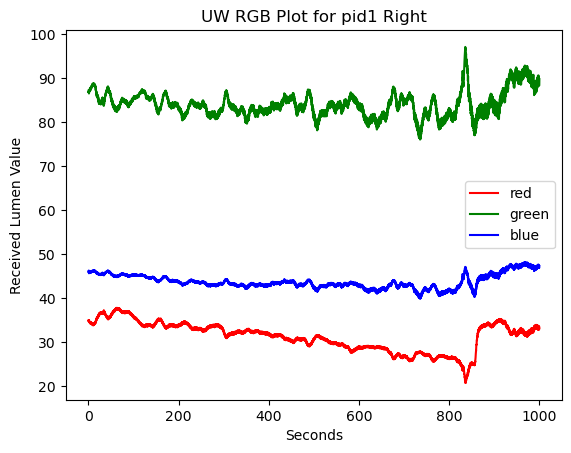

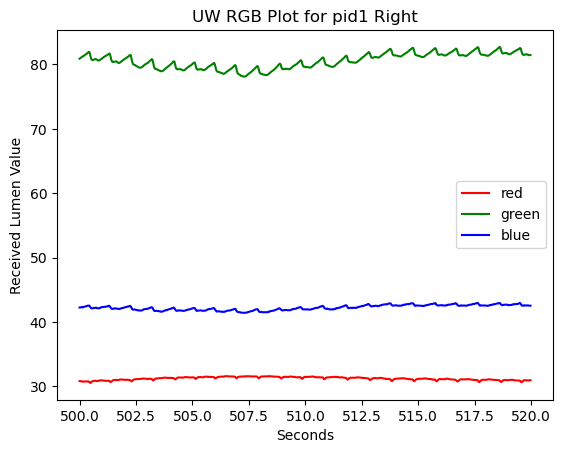

In [6]:
# Plot the red, green, and blue chanel in the time range. Choose either left or right hand.
def plot_RGB(data, pid=0, left=True, sec_from=0, sec_to=1000):
    title = "pid" + str(pid+1)
    X = np.arange(sec_from, sec_to, 1/30)
    if left:
        plt.plot(X, data[pid, 0, sec_from*30:sec_to*30], label="red", color="red")
        plt.plot(X, data[pid, 1, sec_from*30:sec_to*30], label="green", color="green")
        plt.plot(X, data[pid, 2, sec_from*30:sec_to*30], label="blue", color="blue")
        title += " Left"
    else:
        plt.plot(X, data[pid, 3, sec_from*30:sec_to*30], label="red", color="red")
        plt.plot(X, data[pid, 4, sec_from*30:sec_to*30], label="green", color="green")
        plt.plot(X, data[pid, 5, sec_from*30:sec_to*30], label="blue", color="blue")
        title += " Right"
    plt.title("UW RGB Plot for " + title)
    plt.legend()
    plt.xlabel("Seconds")
#     plt.ylim(0, 250)
    plt.ylabel("Received Lumen Value")
    plt.show()
    
plot_RGB(data, pid=0, left=False, sec_from=0, sec_to=1000)
plot_RGB(data, pid=0, left=False, sec_from=500, sec_to=520)

In [7]:
# Make a list of data points for visualizing or training
def make_temp_data(data_uw, groundtruth_uw, data_idx=[], gt_ind = 3):
    # Select 0th sample, right hand
    res_data_list = []
    res_gt_list = []
    for pid, row in enumerate(data_idx):
        if row[0] == 1:
            res_data_list.append(data_uw[pid][:3,:])
            res_gt_list.append(groundtruth_uw[pid][gt_ind,:])
        if row[1] == 1:
            res_data_list.append(data_uw[pid][3:,:]) 
            res_gt_list.append(groundtruth_uw[pid][gt_ind, :])

    results_data_list = []
    results_gt_list = []
    fps_list = []
    for i in range(len(res_gt_list)):
        # find zeros
        zeros_data = np.where(res_data_list[i][0] == 0)[0]
        zeros_gt = np.where(res_gt_list[i] == 0)[0]

        if len(zeros_data) > 0:
            result_data_i = res_data_list[i][:, :int(zeros_data[0])]
        else:
            result_data_i = res_data_list[i]
        if len(zeros_gt) > 0:
            result_gt_i = res_gt_list[i][:int(zeros_gt[0])]
        else:
            result_gt_i = res_gt_list[i]

        # Calculate shorter and clip
        fps = 30
        clip_len = min(result_gt_i.shape[0], result_data_i.shape[1] // fps)
        result_data_i = result_data_i[:, :clip_len*fps]
        result_gt_i = result_gt_i[:clip_len]

        results_gt_list.append(result_gt_i)
        results_data_list.append(result_data_i)
        fps_list.append(fps)

    return {"data": results_data_list, "gt": results_gt_list, "fps": fps_list}

UW: mean=87.220673, std=9.325543


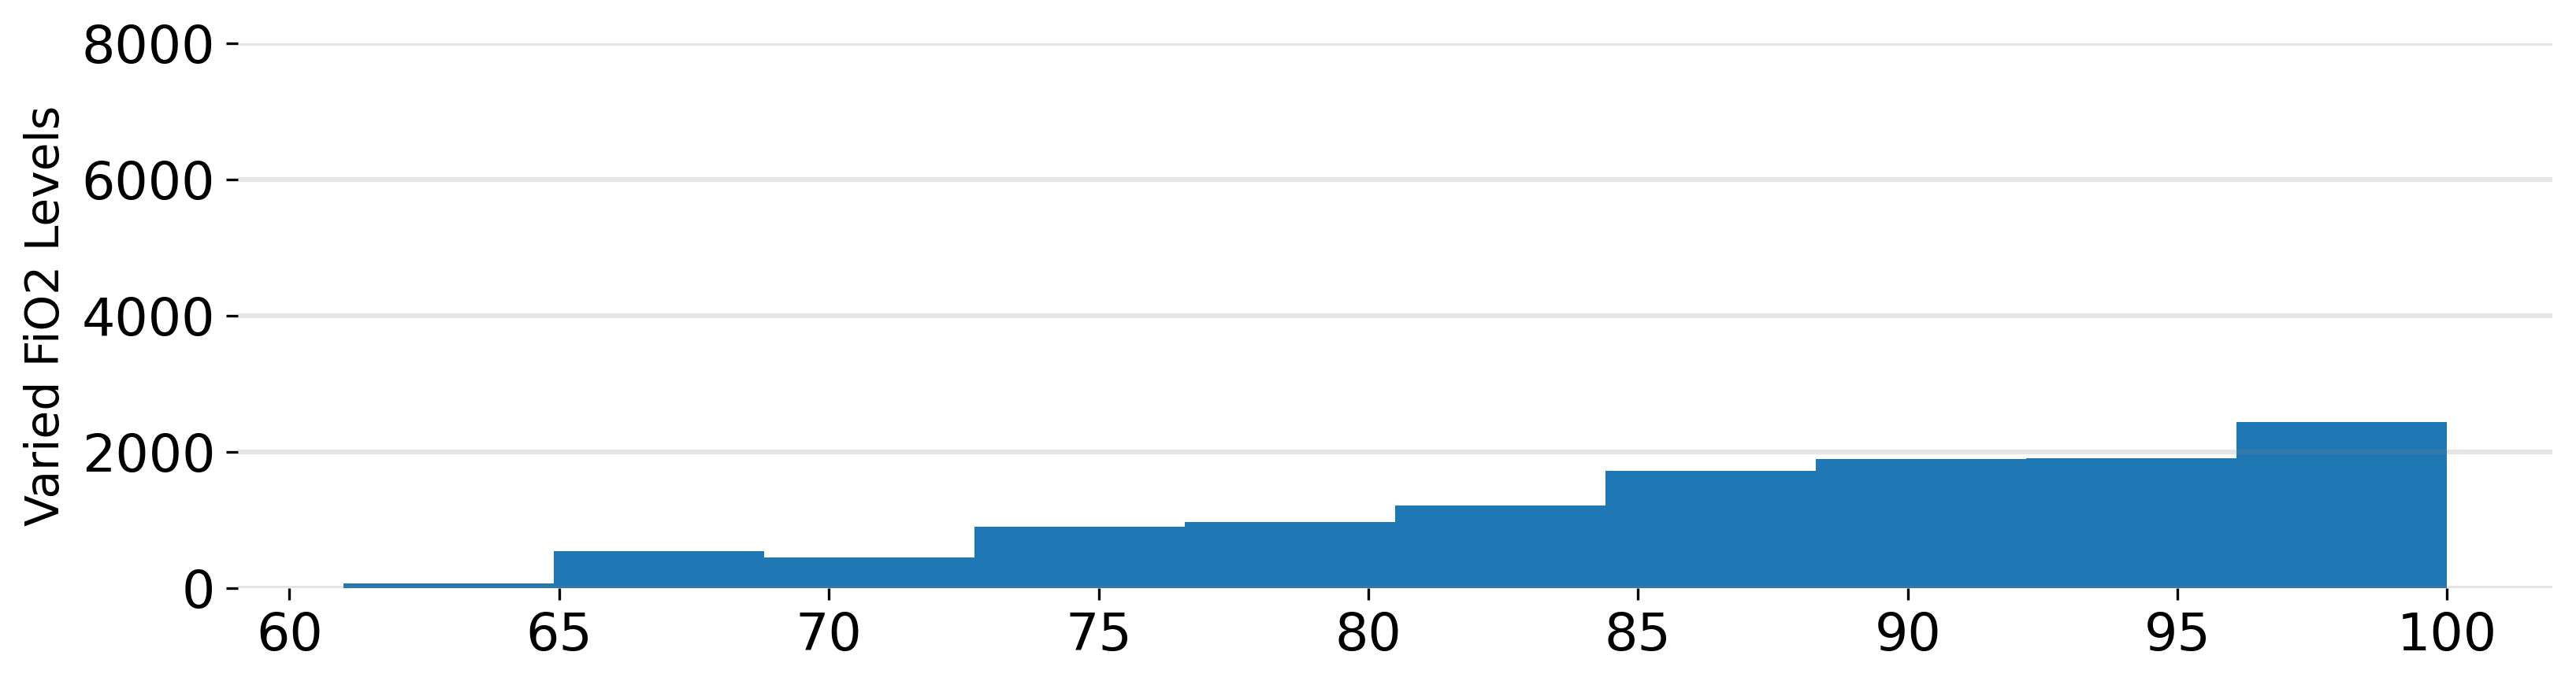

In [5]:
# Plot a historgram of the data distribution
def hist_UW():
    all_data_idx = np.ones((6,2))
    all_seq = make_temp_data(data, groundtruth, gt_ind=3, data_idx=all_data_idx)
    gtdatapoints = []
    for seq in all_seq["gt"]:
        gtdatapoints.extend(seq)
    gtdatapoints = np.array(gtdatapoints)
    print('UW: mean=%f, std=%f' % \
          (np.mean(gtdatapoints),np.std(gtdatapoints)))
    plt.figure(figsize=(11,3),dpi=300)
    plt.hist(gtdatapoints,bins=10, )
    ax = plt.gca()

    ax.set_ylim(top=8000)

    locs = ax.yaxis.get_ticklocs()
    labs = ax.yaxis.get_ticklabels()
    # print([lab.get_text() for lab in ax.yaxis.get_ticklabels()])
    new_locs = []
    new_labs = []
    for i, (loc, lab) in enumerate(list(zip(locs, labs))):
        if (i) % 2 == 0:
            # if i == 0:
            #     continue
            new_locs.append(loc)
            new_labs.append(lab)
            plt.axhline(y=loc, color="grey", alpha=0.2)

    ax.set_yticks(new_locs)
    ax.set_yticklabels(["0", "2000", "4000", "6000", "8000"], fontsize=16)

    # ax.set_xticks(ax.get_xticks(), fontsize=16)
    plt.setp(ax.get_xticklabels(), fontsize=16)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

    ax.set_ylabel("Varied FiO2 Levels", fontsize=14)
    plt.tight_layout()

hist_UW()

In [12]:
import os
print(os.path.exists(f'{PATH}/../gt/metadata.csv'))   # True 才是对的


False


In [13]:

#location of the author folder 
PATH = '../spo2-phonecam/external/oximetry-phone-cam-data/data/preprocessed'  # 字符串

def load_metadata(metapath):
    import pandas as pd
    return pd.read_csv(metapath)

# View metadata descriptions
meta_df = load_metadata(metapath=f'{PATH}/../gt/metadata.csv')
print(meta_df.shape)


(44, 3)


In [14]:
# View metadata descriptions
def load_metadata(metapath):
    meta_df = pd.read_csv(metapath)
#     print()
    return meta_df

load_metadata(metapath=f'{PATH}//..//gt/metadata.csv')

,Label,Description,Unit
0,SpO2 1,SpO2 reading from PPG of pulse ox 1 (3900P TT+...,Percentage
1,SpO2 2,SpO2 reading from PPG of pulse ox 2 (Nellcor N...,Percentage
2,SpO2 3,Unfilled signal from pulse ox 3 (Safety Oxim 3...,Unknown
3,SpO2 4,SpO2 reading from PPG of pulse ox 4 (Nellcor N...,Percentage
4,SpO2 5,SpO2 reading from PPG of pulse ox 5 (Masimo Ra...,Percentage
5,Pulse 1,Heart rate from PPG of pulse ox 1 (3900P TT+ 9...,bpm
6,Pulse 2,Heart rate from PPG of pulse ox 2 (Nellcor N-6...,bpm
7,Pulse 3,Unfilled signal from pulse ox 3 (Safety Oxim 3...,Unknown
8,Pulse 4,Heart rate from PPG of pulse ox 4 (Nellcor N-6...,bpm
9,Pulse 5,Heart rate from PPG of pulse ox 5 (Masimo Radi...,bpm


In [92]:
# === Imports & global settings ===
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (mean_absolute_error, roc_auc_score, roc_curve,
                             precision_recall_curve, average_precision_score,
                             confusion_matrix)
from math import sqrt

# Reproducibility
np.random.seed(42)
plt.rcParams['figure.dpi'] = 140
plt.rcParams['axes.grid'] = True

# === Experiment config (edit here) ===
DEVICE_IDX = 0
LAG_SEC    = 40          # candidate: 30/40/50
WIN        = 150         # candidate: 120/150
LOW_WEIGHT = 12.0        # candidate: 8/12/16
THR_LOW    = 90.0        # hypoxemia threshold


In [93]:
# NOTE: This uses the author's processed signals (not raw videos).
# Functions assumed to exist in your repo:
# - make_besthand_v3_with_lag_dcNorm(data, groundtruth, device_idx, lag_sec, acdc_thr, win)
# 'data' and 'groundtruth' should be prepared as in the original repo scripts.

Xb, yb, ob = make_besthand_v3_with_lag_dcNorm(
    data, groundtruth,
    device_idx=DEVICE_IDX, lag_sec=LAG_SEC, acdc_thr=0.02, win=WIN
)

print("X shape:", Xb.shape, "y shape:", yb.shape, "n subjects:", len(np.unique(ob)))


[besthand v3 + lag=40s, dcNorm] X: (4786, 3, 150) y: (4786,)
X shape: (4786, 3, 150) y shape: (4786,) n subjects: 6


In [94]:
# Assumes the training runner returns:
#   y_true, y_pred: concatenated OOF predictions aligned with yb
#   per: list of per-fold dicts containing 'mae' etc.

y_true, y_pred, per = run_loso_with_iso_cal_v2(
    Xb, yb, ob,
    model_factory=lambda in_ch: Shallow1DCNN(in_ch),
    epochs=180, base_lr=3e-4, wd=5e-4, bs=256,
    patience=25, low_weight=LOW_WEIGHT
)

mae = float(np.mean([r["mae"] for r in per]))
print(f"[WIN={WIN}, lag={LAG_SEC}, low_w={LOW_WEIGHT}]  LOSO mean MAE = {mae:.3f}%")


device: mps
[LOSO+iso] held=0 MAE=4.128% n=175 (flip=-1)
[LOSO+iso] held=1 MAE=7.383% n=1047 (flip=-1)
[LOSO+iso] held=2 MAE=7.220% n=990 (flip=-1)
[LOSO+iso] held=3 MAE=5.351% n=972 (flip=-1)
[LOSO+iso] held=4 MAE=7.482% n=851 (flip=-1)
[LOSO+iso] held=5 MAE=7.929% n=751 (flip=-1)
[WIN=150, lag=40, low_w=12.0]  LOSO mean MAE = 6.582%


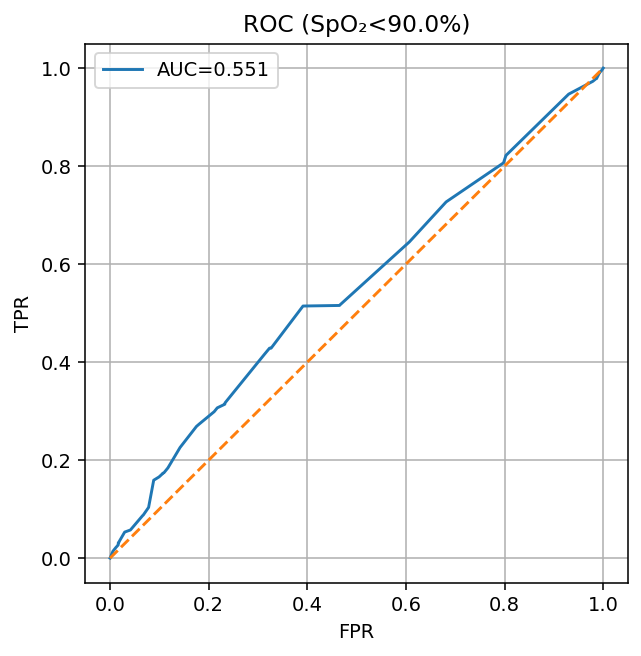

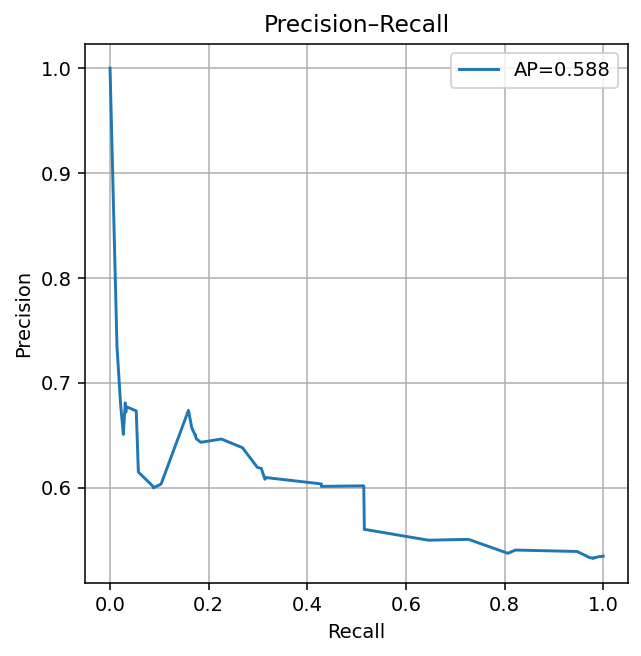

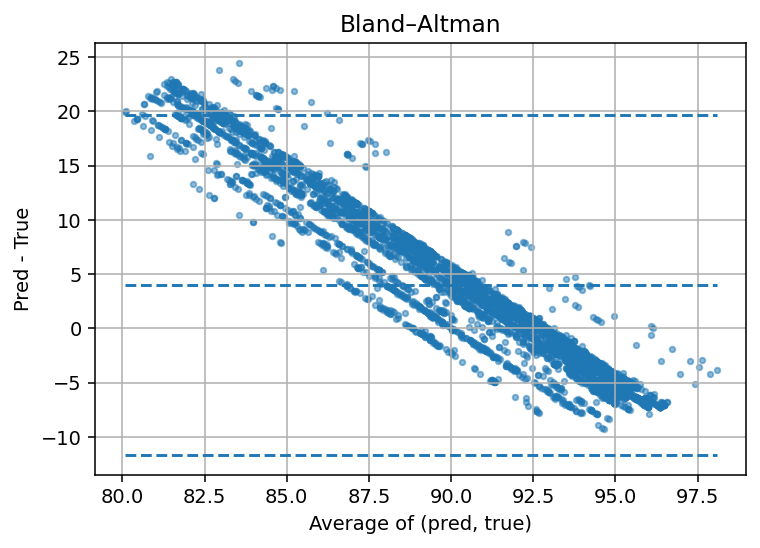

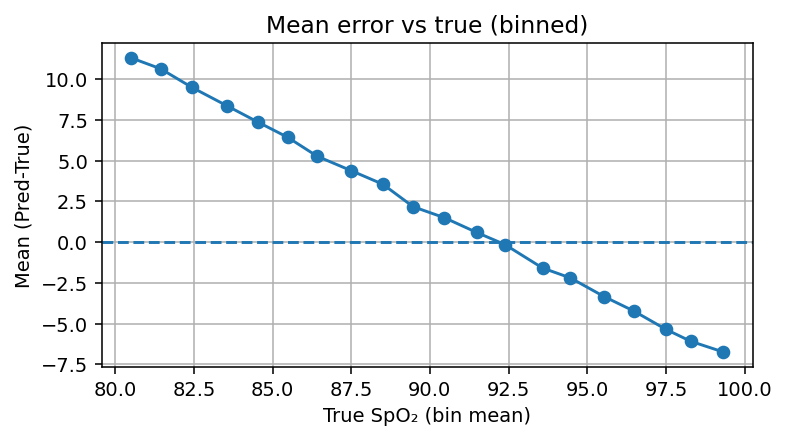

In [96]:
# ROC
fpr, tpr, _ = roc_curve(pos, scores)
plt.figure(figsize=(5,5)); plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],'--'); plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title(f"ROC (SpO₂<{THR_LOW}%)"); plt.legend(); plt.show()

# PR curve (more informative for class imbalance)
prec, rec, _ = precision_recall_curve(pos, scores)
plt.figure(figsize=(5,5)); plt.plot(rec, prec, label=f"AP={ap:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall"); plt.legend(); plt.show()

# Bland–Altman
avg = (y_true + y_pred)/2.0
diff = (y_pred - y_true)
m = np.isfinite(avg) & np.isfinite(diff)
avg, diff = avg[m], diff[m]
md, sd = float(np.mean(diff)), float(np.std(diff))
plt.figure(figsize=(6,4))
plt.scatter(avg, diff, s=8, alpha=0.5)
for z in [0, 1.96, -1.96]:
    plt.hlines(md + z*sd, xmin=np.min(avg), xmax=np.max(avg), linestyles="--")
plt.xlabel("Average of (pred, true)"); plt.ylabel("Pred - True")
plt.title("Bland–Altman"); plt.show()

# Error vs True (diagnose proportional bias)
bins = np.arange(80, 100.1, 1.0)
digit = np.digitize(y_true, bins)-1
means_true = []; means_err = []; counts=[]
for b in range(len(bins)-1):
    m = digit==b
    if m.sum():
        means_true.append(np.mean(y_true[m]))
        means_err.append(np.mean(y_pred[m]-y_true[m]))
        counts.append(int(m.sum()))
plt.figure(figsize=(6,3))
plt.plot(means_true, means_err, marker='o')
plt.axhline(0, ls='--')
plt.xlabel("True SpO₂ (bin mean)"); plt.ylabel("Mean (Pred-True)")
plt.title("Mean error vs true (binned)"); plt.show()


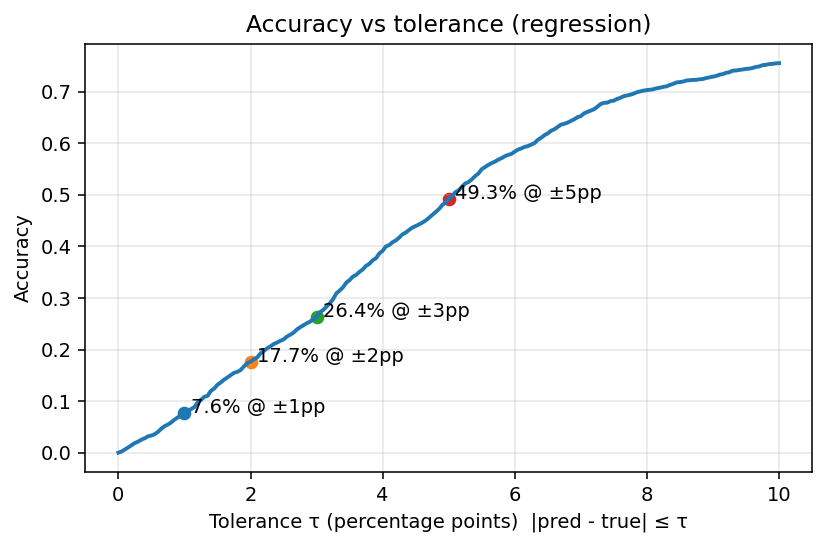

Acc within ±1pp: 7.6%
Acc within ±2pp: 17.7%
Acc within ±3pp: 26.4%
Acc within ±5pp: 49.3%


In [97]:
# --- Accuracy vs tolerance curve (a.k.a. cumulative error distribution) ---
import numpy as np, matplotlib.pyplot as plt

y_true = np.asarray(y_true).ravel()
y_pred = np.asarray(y_pred).ravel()
m = np.isfinite(y_true) & np.isfinite(y_pred)
y_true, y_pred = y_true[m], y_pred[m]

abs_err = np.abs(y_pred - y_true)          # error in percentage points (pp)
taus = np.linspace(0.0, 10.0, 201)         # 0~10 pp
acc = (abs_err[:, None] <= taus[None, :]).mean(axis=0)

plt.figure(figsize=(6,4), dpi=140)
plt.plot(taus, acc, lw=2)
plt.xlabel("Tolerance τ (percentage points)  |pred - true| ≤ τ")
plt.ylabel("Accuracy")
plt.title("Accuracy vs tolerance (regression)")
plt.grid(alpha=0.3)

# Annotate a few typical tolerances
for t in [1, 2, 3, 5]:
    i = np.searchsorted(taus, t)
    plt.scatter([taus[i]], [acc[i]])
    plt.text(taus[i]+0.1, acc[i], f"{acc[i]*100:.1f}% @ ±{t}pp")

plt.tight_layout(); plt.show()

# Print key points as numbers
def tol_acc(t):
    i = np.searchsorted(taus, t)
    return acc[i]
print(f"Acc within ±1pp: {tol_acc(1)*100:.1f}%")
print(f"Acc within ±2pp: {tol_acc(2)*100:.1f}%")
print(f"Acc within ±3pp: {tol_acc(3)*100:.1f}%")
print(f"Acc within ±5pp: {tol_acc(5)*100:.1f}%")


In [98]:
import numpy as np
from sklearn.metrics import r2_score

y_true = np.asarray(y_true).ravel()
y_pred = np.asarray(y_pred).ravel()
m = np.isfinite(y_true) & np.isfinite(y_pred)
y_true, y_pred = y_true[m], y_pred[m]
err = y_pred - y_true

# 1) 回归精度（对真值）
mae  = np.mean(np.abs(err))                         # Mean Absolute Error
arms = np.sqrt(np.mean(err**2))                     # Accuracy RMS (A_rms)
r2   = r2_score(y_true, y_pred)                     # R^2 correlation

print(f"MAE = {mae:.2f}%")
print(f"A_rms = {arms:.2f}%   (FDA/ISO reflectance spec ≈ 3.5%)")
print(f"R^2 = {r2:.3f}")

# 2) 区段化精度（70–80 / 80–90 / 90–100），与论文口径一致
bins = [(70,80),(80,90),(90,100)]
for lo,hi in bins:
    m2 = (y_true>=lo) & (y_true<hi)
    if m2.sum():
        e = y_pred[m2]-y_true[m2]
        mae_i  = np.mean(np.abs(e))
        arms_i = np.sqrt(np.mean(e**2))
        print(f"[{lo}-{hi})  n={m2.sum():4d}  MAE={mae_i:.2f}%  A_rms={arms_i:.2f}%")

# 3) “±τ 内准确率”关键点（和你那条曲线对应的数值）
for t in [1,2,3,5]:
    acc_t = (np.abs(err) <= t).mean()
    print(f"Accuracy within ±{t}pp = {acc_t*100:.1f}%")


MAE = 6.92%
A_rms = 8.95%   (FDA/ISO reflectance spec ≈ 3.5%)
R^2 = -0.262
[70-80)  n= 921  MAE=16.89%  A_rms=17.16%
[80-90)  n=1639  MAE=6.13%  A_rms=6.88%
[90-100)  n=2191  MAE=3.33%  A_rms=3.89%
Accuracy within ±1pp = 7.6%
Accuracy within ±2pp = 17.7%
Accuracy within ±3pp = 26.4%
Accuracy within ±5pp = 49.3%


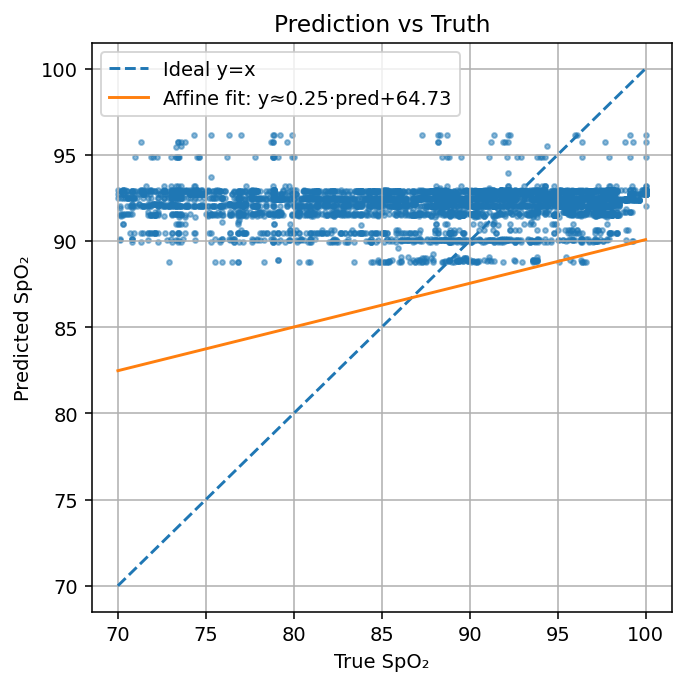

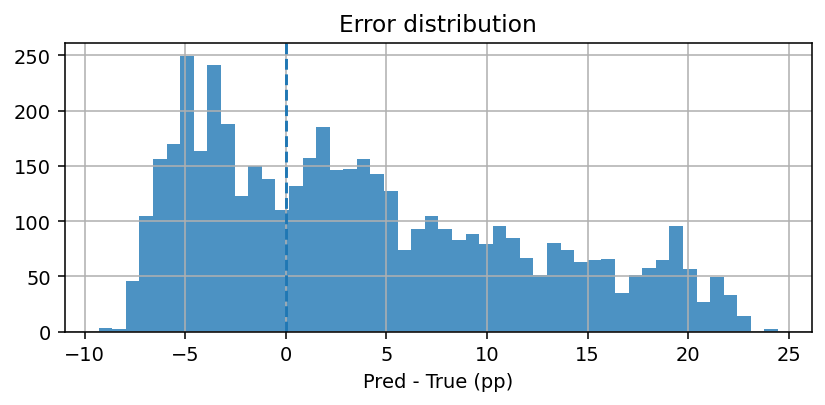

In [99]:
import matplotlib.pyplot as plt

# A) Pred vs True 散点（带 y=x 线 + 仿射拟合线）
plt.figure(figsize=(5,5), dpi=140)
plt.scatter(y_true, y_pred, s=6, alpha=0.5)
x = np.linspace(y_true.min(), y_true.max(), 100)
plt.plot(x, x, '--', label='Ideal y=x')
# 可选：仿射拟合线（看整体偏差）
A = np.vstack([np.ones_like(y_pred), y_pred]).T
a, b = np.linalg.lstsq(A, y_true, rcond=None)[0]
plt.plot(x, (x*b + a), label=f'Affine fit: y≈{b:.2f}·pred+{a:.2f}')
plt.xlabel("True SpO₂"); plt.ylabel("Predicted SpO₂")
plt.title("Prediction vs Truth"); plt.legend(); plt.tight_layout(); plt.show()

# B) 误差直方图 / KDE
plt.figure(figsize=(6,3), dpi=140)
plt.hist(err, bins=50, alpha=0.8)
plt.axvline(0, ls='--'); plt.xlabel("Pred - True (pp)")
plt.title("Error distribution"); plt.tight_layout(); plt.show()


MAE = 6.92%
A_rms (RMSE) = 8.95%   [FDA/ISO reflectance spec ≈ 3.5%]
R^2 = -0.262
[70-80)  n= 921  MAE=16.89%  A_rms=17.16%
[80-90)  n=1639  MAE=6.13%  A_rms=6.88%
[90-100]  n=2226  MAE=3.38%  A_rms=3.96%
Accuracy within ±1pp = 7.6%
Accuracy within ±2pp = 17.7%
Accuracy within ±3pp = 26.4%
Accuracy within ±5pp = 49.3%


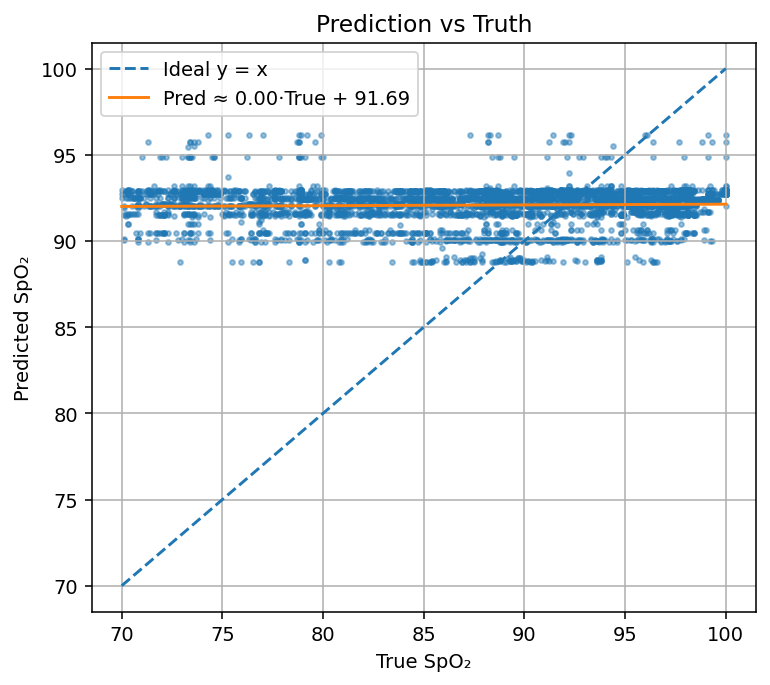

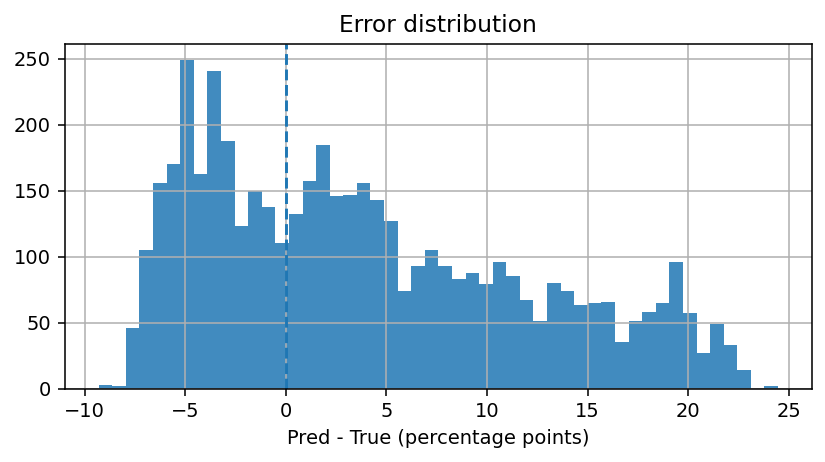

In [100]:
# === Prediction vs Truth: metrics + plots (corrected affine fit) ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# y_true, y_pred must already exist (1D arrays). This cell only evaluates/plots.
y_true = np.asarray(y_true).ravel()
y_pred = np.asarray(y_pred).ravel()

# Clean NaN/Inf
mask = np.isfinite(y_true) & np.isfinite(y_pred)
y_true, y_pred = y_true[mask], y_pred[mask]

# Errors (in percentage points)
err = y_pred - y_true

# 1) Global regression accuracy (against truth)
mae  = np.mean(np.abs(err))                 # Mean Absolute Error
arms = np.sqrt(np.mean(err**2))             # RMSE = A_rms
r2   = r2_score(y_true, y_pred)             # Coefficient of determination

print(f"MAE = {mae:.2f}%")
print(f"A_rms (RMSE) = {arms:.2f}%   [FDA/ISO reflectance spec ≈ 3.5%]")
print(f"R^2 = {r2:.3f}")

# 2) Stratified accuracy by true SpO2 ranges (70–80 / 80–90 / 90–100)
bins = [(70,80), (80,90), (90,100)]
for lo, hi in bins:
    # include 100 in the last bin
    m2 = (y_true >= lo) & (y_true < hi if hi < 100 else y_true <= hi)
    if np.any(m2):
        e = y_pred[m2] - y_true[m2]
        mae_i  = np.mean(np.abs(e))
        arms_i = np.sqrt(np.mean(e**2))
        right_bracket = ')' if hi < 100 else ']'
        print(f"[{lo}-{hi}{right_bracket}  n={m2.sum():4d}  MAE={mae_i:.2f}%  A_rms={arms_i:.2f}%")

# 3) Key points on the “accuracy within ±τ” curve
for t in (1, 2, 3, 5):
    acc_t = (np.abs(err) <= t).mean()
    print(f"Accuracy within ±{t}pp = {acc_t*100:.1f}%")

# 4) Plots
# A) Prediction vs Truth scatter with ideal line and CORRECT affine fit
plt.figure(figsize=(5.6, 5.0), dpi=140)
plt.scatter(y_true, y_pred, s=6, alpha=0.45)
x = np.linspace(np.min(y_true), np.max(y_true), 200)
plt.plot(x, x, '--', label='Ideal y = x')

# CORRECT orientation: fit y_pred on y_true (axes-aligned)
B = np.vstack([np.ones_like(y_true), y_true]).T   # columns: [1, true]
a, b = np.linalg.lstsq(B, y_pred, rcond=None)[0]
plt.plot(x, a + b*x, label=f'Pred ≈ {b:.2f}·True + {a:.2f}')

plt.xlabel("True SpO₂")
plt.ylabel("Predicted SpO₂")
plt.title("Prediction vs Truth")
plt.legend()
plt.tight_layout()
plt.show()

# B) Error histogram
plt.figure(figsize=(6.0, 3.4), dpi=140)
plt.hist(err, bins=50, alpha=0.85)
plt.axvline(0.0, ls='--')
plt.xlabel("Pred - True (percentage points)")
plt.title("Error distribution")
plt.tight_layout()
plt.show()
